In [2]:
import cv2
import time
import pickle
import skimage.io
import numpy as np
import tkinter as tk
from functions import *
from tkinter import *
import scipy.stats as st
from matplotlib import pyplot as plt
from tkinter import filedialog as fd
from tkinter import messagebox as mb

numpy_types = {
    'unsigned char': 'uint8',
    'unsigned short': 'uint16',
    'unsigned long': 'uint32',
    'unsigned long long': 'uint64'
}

with open("types.pkl", "rb") as f:
    types = pickle.load(f)
    
img = skimage.io.imread('dock.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

class Retina:
    def __init__(self):
        self.backProjectedVector = None
        self.normalizationVector = None
        self.quantization_bits = None
        self.optimumNumThreads = None
        self.input_resolution = None
        self.sampledVector = None
        self.coeff_layers = None
        self.index_layers = None
        self.retina_size = None
        self.crop_coords = None
        self.backProject = None
        self.fixation = None
        self.sample = None
        self.coeffs = None
        self.locs = None
        self.cap = None
        self.h = None
        self.w = None
        
        try:
            self.loadLayers()
        except:
            print("Could not find previously saved layers, Please make sure to initlaize them!")
    
    def loadLocations(self):
        root = Tk()
        root.attributes("-topmost", True)
        root.withdraw()
        i = 0
        while self.locs is None:
            i+= 1
            try:
                fname = fd.askopenfilename(title = "Select locations data", filetypes = (("Pickle Object","*.pkl"),("all files","*.*")))
                with open(fname, "rb" ) as f:
                    self.locs = pickle.load(f , encoding='latin1')
                if self.locs.shape[-1] != 7:
                    mb.showerror("Failed!", "Data has wrong dimensions.\nPlease make sure you have selected the correct file", parent=root)
                    self.locs = None
            except:
                self.locs = None
                mb.showerror("Failed!", "Something went wrong while trying to load location data.\nPlease make sure you have selected the correct file and that the file is not in use by other processes.", parent=root)
            if self.locs is None and i>=3:
                if mb.askyesno("Data not loaded correctly!", "Would you like to abort?", parent=root):
                    break
        if self.locs is None:
            quit()
        root.destroy()
        w = 2*int(np.max(np.abs(self.locs[:,0])) + np.max(self.locs[:,6]//2)+1)
        h = 2*int(np.max(np.abs(self.locs[:,1])) + np.max(self.locs[:,6]//2)+1)
        self.retina_size = np.array([h,w], dtype='int32')
        
    def loadCoefficients(self):
        root = Tk()
        root.attributes("-topmost", True)
        root.withdraw()
        i = 0
        while self.coeffs is None:
            i+= 1
            try:
                fname = fd.askopenfilename(title = "Select coefficients data", filetypes = (("Pickle Object","*.pkl"),("all files","*.*")))
                with open(fname, "rb" ) as f:
                    self.coeffs = np.squeeze(pickle.load(open(fname, "rb" ), encoding='latin1'))
                if len(self.coeffs.shape) != 1:
                    mb.showerror("Failed!", "Data has wrong dimensions.\nPlease make sure you have selected the correct file", parent=root)
                    self.coeffs = None
            except:
                self.coeffs = None
                mb.showerror("Failed!", "Something went wrong while trying to load coefficients data.\nPlease make sure you have selected the correct file and that the file is not in use by other processes.", parent=root)
            if self.coeffs is None and i>=3:
                if mb.askyesno("Data not loaded correctly!", "Would you like to abort?", parent=root):
                    break
        if self.coeffs is None:
            quit()
        self.sampledVector = np.zeros(len(self.locs)+1).astype(numpy_types[types['RESULTS']])

    def loadLayers(self):
        with open("layers.pkl", "rb") as f:
            self.coeff_layers, self.index_layers, idx = pickle.load(f)
        self.sampledVector = np.zeros(idx).astype(numpy_types[types['RESULTS']])

    def packPixels(self):
        ######################################
        ########### INITIALIZATION ###########
        ######################################
        h, w = self.retina_size
        self.locs[:,:2] = (self.locs[:,:2]+ np.array((w//2,h//2)))
        overlapCounter = np.zeros((h,w),dtype='uint8')
        #######################################
        ###### FINDING OVERLAPPING AREAS ######
        #######################################
        for idx in range(len(self.locs)):
            size = int(self.locs[idx][6])
            offset = size/2.0
            x , y = np.round(self.locs[idx][:2])
            x1,y1,x2,y2 = int(x-offset),int(y-offset),int(x+offset),int(y+offset)
            overlapCounter[y1:y2,x1:x2] += 1
        nLayers = np.max(overlapCounter)
        self.coeff_layers = []
        [self.coeff_layers.append(np.zeros((h,w))) for i in range(nLayers)]
        self.index_layers = []
        [self.index_layers.append(np.zeros((h,w))) for i in range(nLayers)]
        ######################################
        ########### PACKING PIXELS ###########
        ######################################
        for idx in range(len(self.locs)):
            values = self.coeffs[idx]
            size = int(self.locs[idx][6])
            offset = size/2.0
            x , y = np.round(self.locs[idx][:2])
            pixelCoords = [(int(x+i-offset), int(y+j-offset), values[j,i]) for j in range(size) for i in range(size)]
            for coord in pixelCoords:
                a , b , c = coord
                for i in range(nLayers):
                    if self.coeff_layers[i][b,a] == 0:
                        self.coeff_layers[i][b,a] = c
                        self.index_layers[i][b,a] = idx+1
                        break
        #######################################
        ###### CONVERTING FLOATS TO INTS ######
        #######################################
        scaling_factor = ((2**self.quantization_bits)-1) / np.max(self.coeff_layers)
        for i in range(len(self.coeff_layers)):
            self.coeff_layers[i] = (self.coeff_layers[i]*scaling_factor).astype(numpy_types[types['COEFFICIENTS']])
            self.index_layers[i] = self.index_layers[i].astype(numpy_types[types['INDEX']])
        ######################################
        ######### SAVING THE RESULTS #########
        ######################################
        with open("layers.pkl", "wb") as f:
            pickle.dump((self.coeff_layers,self.index_layers,len(self.locs)+1), f)
        self.locs = None
        self.coeffs = None
            
    def packKernels(self):
        ######################################
        ########### INITIALIZATION ###########
        ######################################
        h, w = self.retina_size
        self.locs[:,:2] = (self.locs[:,:2]+ np.array((w//2,h//2)))
        #######################################
        ########### PACKING KERNELS ###########
        #######################################
        for idx in range(len(self.locs)):
            size = int(self.locs[idx][6])
            offset = size/2.0
            x , y = np.round(self.locs[idx][:2])
            x1,y1,x2,y2 = int(x-offset),int(y-offset),int(x+offset),int(y+offset)
            found_empty_layer = False
            for x in range(len(self.coeff_layers)):
                coeff_layer = self.coeff_layers[x]
                index_layer = self.index_layers[x]
                if len(coeff_layer[np.where(coeff_layer[y1:y2,x1:x2]>0)])==0:
                    coeff_layer[y1:y2,x1:x2] = self.coeffs[idx]
                    index_layer[y1:y2,x1:x2] = idx+1
                    found_empty_layer = True
                    break
            if not found_empty_layer:
                self.coeff_layers.append(np.zeros((h,w)))
                self.index_layers.append(np.zeros((h,w)))

                self.coeff_layers[-1][y1:y2,x1:x2] = self.coeffs[idx]
                self.index_layers[-1][y1:y2,x1:x2] = idx+1
        #######################################
        ###### CONVERTING FLOATS TO INTS ######
        #######################################
        scaling_factor = ((2**self.quantization_bits)-1) / np.max(self.coeff_layers)
        for i in range(len(self.coeff_layers)):
            self.coeff_layers[i] = (self.coeff_layers[i]*scaling_factor).astype(numpy_types[types['COEFFICIENTS']])
            self.index_layers[i] = self.index_layers[i].astype(numpy_types[types['INDEX']])
        ######################################
        ######### SAVING THE RESULTS #########
        ######################################
        with open("layers.pkl", "wb") as f:
            pickle.dump((self.coeff_layers,self.index_layers,len(self.locs)+1), f)
        self.locs = None
        self.coeffs = None
        
    def setInputResolution(self, w, h):
        self.input_resolution = np.array([h,w], dtype='int32')
        
    def setFixation(self, x, y):
        with open("layers.pkl", "rb") as f:
            layers = pickle.load(f)
        if self.coeff_layers is None:
            self.coeff_layers = layers[0]
            self.index_layers = layers[1]
        if self.retina_size is None:
            self.retina_size = np.array(layers[0][0].shape, dtype='int32')
        self.fixation = np.array([x,y], dtype='int32')
        img_x1, img_y1, img_x2, img_y2, ret_x1, ret_y1, ret_x2, ret_y2 = get_bounds(self.input_resolution, self.retina_size, self.fixation)
        self.crop_coords = (img_x1, img_y1, img_x2, img_y2)
        for i in range(len(layers[0])):
            self.coeff_layers[i] = layers[0][i][ret_y1:ret_y2, ret_x1:ret_x2].flatten()
            self.index_layers[i] = layers[1][i][ret_y1:ret_y2, ret_x1:ret_x2].flatten()
        self.h = img_y2 - img_y1
        self.w = img_x2 - img_x1
            
    def sample_gray(self, img):
        zeros_int32(self.sampledVector)
        x1, y1, x2, y2 = self.crop_coords
        img = img[y1:y2, x1:x2].flatten()
        for i in range(len(self.coeff_layers)):
            sample(img, self.coeff_layers[i], self.index_layers[i], self.sampledVector)
            
    def createNormalizationImage_gray(self):
        self.backProjectedVector = np.zeros(self.retina_size).astype(numpy_types[types['BAKC_PROJECTED']]).flatten()
        ones = np.ones(self.input_resolution).astype(numpy_types[types['INPUT']])
        self.sample(ones)
        for i in range(len(self.coeff_layers)):
            backProject(self.sampledVector,  self.coeff_layers[i],  self.index_layers[i],  self.backProjectedVector)
        self.normalizationVector = np.copy(self.backProjectedVector)
        self.normalizationVector[np.where(self.normalizationVector==0)]=1
            
    def backProject_gray(self):
        zeros_int32(self.backProjectedVector)
        for i in range(len(self.coeff_layers)):
            backProject(self.sampledVector,  self.coeff_layers[i],  self.index_layers[i],  self.backProjectedVector)
        normalize(self.backProjectedVector, self.normalizationVector)
        
    def calibrate(self, img):
        rgb = (len(img.shape)==3) and (img.shape[-1]==3)
        self.setInputResolution(img.shape[1],img.shape[0])
        self.setFixation(img.shape[1]/2,img.shape[0]/2)
        if rgb:
            self.sample = self.sample_rgb
            self.backProject = self.backProject_rgb
            self.createNormalizationImage = self.createNormalizationImage_rgb
        else:
            self.sample = self.sample_gray
            self.backProject = self.backProject_gray
            self.createNormalizationImage = self.createNormalizationImage_gray
        self.createNormalizationImage()

In [5]:
def show_backProjected(retina, figsize=(16,9)):
    plt.figure(figsize=figsize)
    plt.imshow(retina.backProjectedVector[:retina.h*retina.w].reshape((retina.h,retina.w)), cmap='gray')
    plt.show()

Path of retina over the image


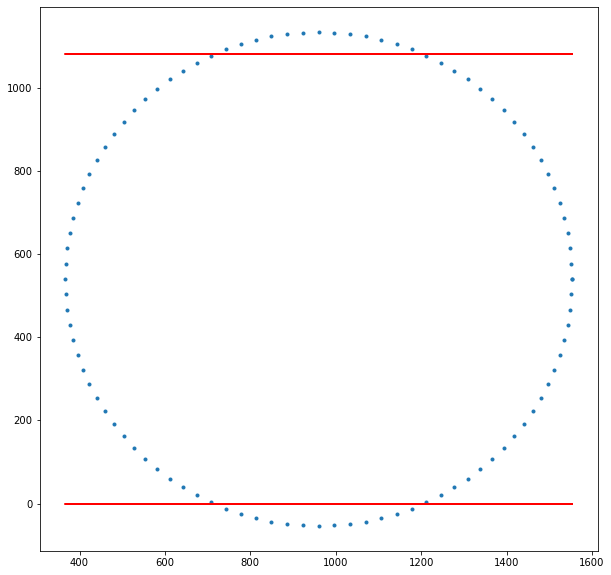

In [3]:
import time

fixation_demo = True

if fixation_demo:
    
    R = Retina()
    R.calibrate(img_gray)
    
    n = 100
    r = 0.55 * R.input_resolution[0]
    xs = np.array([int(np.cos(2*np.pi/n*x)*r) for x in range(0,n+1)]) + R.input_resolution[1]//2
    ys = np.array([int(np.sin(2*np.pi/n*x)*r) for x in range(0,n+1)]) + R.input_resolution[0]//2

    print("Path of retina over the image")
    plt.figure(figsize=(10,10))
    plt.plot(xs,ys, '.')
    plt.plot(xs,[0]*len(xs),'r')
    plt.plot(xs,[R.input_resolution[0]]*len(xs),'r')
    plt.show()

    i = 0
    while True:
        R.setFixation(xs[i],ys[i])
        R.createNormalizationImage()
        R.sample(img_gray)
        R.backProject()
        cv2.imshow('Back Projected',R.backProjectedVector[:R.h*R.w].reshape((R.h,R.w)).astype('uint8'))
        key = cv2.waitKey(1)
        if key == 27: #esc
                break
        i+=1
        if i==len(xs):
            i=0
    cv2.destroyAllWindows()

In [3]:
live_demo = True

if live_demo:
    cap = cv2.VideoCapture(0)

    #Define capture resolution
    #If the actual set values are not supported by the camera,
    #highest supported values below the entered numbers is selected
    cap.set(3, 640)
    cap.set(4, 480)
    ret, calibration_image = cap.read()
    calibration_image = cv2.cvtColor(calibration_image, cv2.COLOR_BGR2GRAY)
    print("Actual resolution was set to %ix%i" %calibration_image.shape[::-1])

    R = Retina()
    R.calibrate(calibration_image)

    try:
        while(cap.isOpened()):
            ret, frame = cap.read()
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            R.sample(gray)
            R.backProject()
            cv2.imshow('Capture',gray)
            cv2.imshow('Back Projected',R.backProjectedVector[:R.h*R.w].reshape((R.h,R.w)).astype('uint8'))
            key = cv2.waitKey(1)
            if key == 27: #esc
                    break
    finally:
        cap.release()
        cv2.destroyAllWindows()

Actual resolution was set to 640x480


# PLEASE IGNORE THE CELLS BELOW
### (FOR DEVELOPMENT PURPOSES ONLY!)

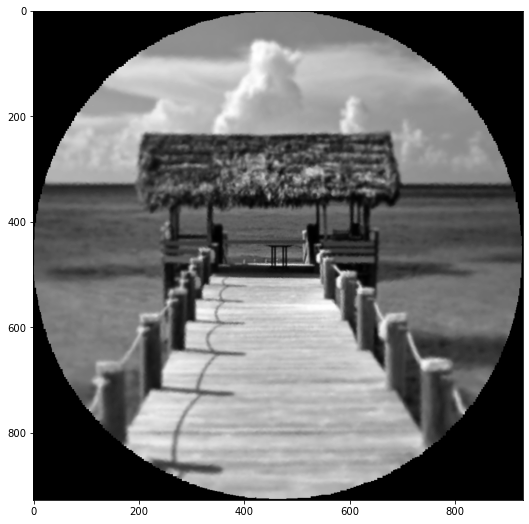

##################################################
Sum of the differences between current sampling result and a known good result:
0.0
##################################################
BEFORE SAMPLING:
Mean ± STD: 100.000 ± 0.000
Range: 100.000 <-> 100.000
##################################################
AFTER SAMPLING:
Mean ± STD: 100.000 ± 0.000
Range: 100.000 <-> 100.000
##################################################


In [22]:
with open("validation_sample.pkl", "rb") as f:
    previous_result = pickle.load(f)

R = Retina()
R.calibrate(img_gray)
R.sample(img_gray)
R.backProject()
diff = sum(R.sampledVector-previous_result)
show_backProjected(R)
quantization_test = (np.ones(R.input_resolution)*100).astype(numpy_types[types['INPUT']])
R.sample(quantization_test)
R.backProject()
print('#'*50)
print("Sum of the differences between current sampling result and a known good result:")
print(diff)
print('#'*50)
print("BEFORE SAMPLING:")
mean = np.mean(quantization_test)
std = np.std(quantization_test)
print("Mean ± STD: %.3f ± %.3f" %(mean, std))
print("Range: %.3f <-> %.3f" %(np.min(quantization_test), np.max(quantization_test)))
print('#'*50)
result = R.backProjectedVector[np.where(R.backProjectedVector > 0)]
mean = np.mean(result)
std = np.std(result)
print("AFTER SAMPLING:")
print("Mean ± STD: %.3f ± %.3f" %(mean, std))
print("Range: %.3f <-> %.3f" %(np.min(result), np.max(result)))
print('#'*50)

In [13]:
R = Retina()
R.quantization_bits = 16
R.loadLocations()
R.loadCoefficients()
R.packPixels()
R.calibrate(img_gray)

In [14]:
%%timeit
R.sample(img_gray)

22.3 ms ± 684 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
R.setFixation(1920/2,1080/2)

In [9]:
%%timeit
R.sample(img_gray)

22.9 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
R.setFixation(1920,1080)

In [11]:
%%timeit
R.sample(img_gray)

5.71 ms ± 79.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit
R.setFixation(1920/2,1080/2)

216 ms ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
import os, psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss/(2**20))

245.046875


In [14]:
import sys
sizes = [sys.getsizeof(layer) for layer in R.coeff_layers]+[sys.getsizeof(layer) for layer in R.index_layers]
print(sum(sizes)/(2**20))

73.91876220703125
